In [44]:
import os
import sys
import cv2
import numpy as np
from skimage.transform import hough_line, hough_line_peaks, pyramid_reduce
from PIL import Image

In [77]:
with Image.open(os.path.join('normalization', 'sample_photo.jpg')) as image:
    image_np = np.array(image)
    image_np = np.swapaxes(image_np, 0, 1)
    print(image_np.shape)
    print(np.max(image_np))
    Image.fromarray(image_np).show()

(4032, 3024, 3)
255


In [68]:
SRC_IMAGE = 'normalization/sample_photo.jpg'

# read image
image = cv2.imread(SRC_IMAGE)
print(type(image))
print(np.max(image))
image_gray = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)
src_h, src_w = image_gray.shape[:2]

print(type(image_gray))
print(image_gray.shape)


<class 'numpy.ndarray'>
255
<class 'numpy.ndarray'>
(3024, 4032)


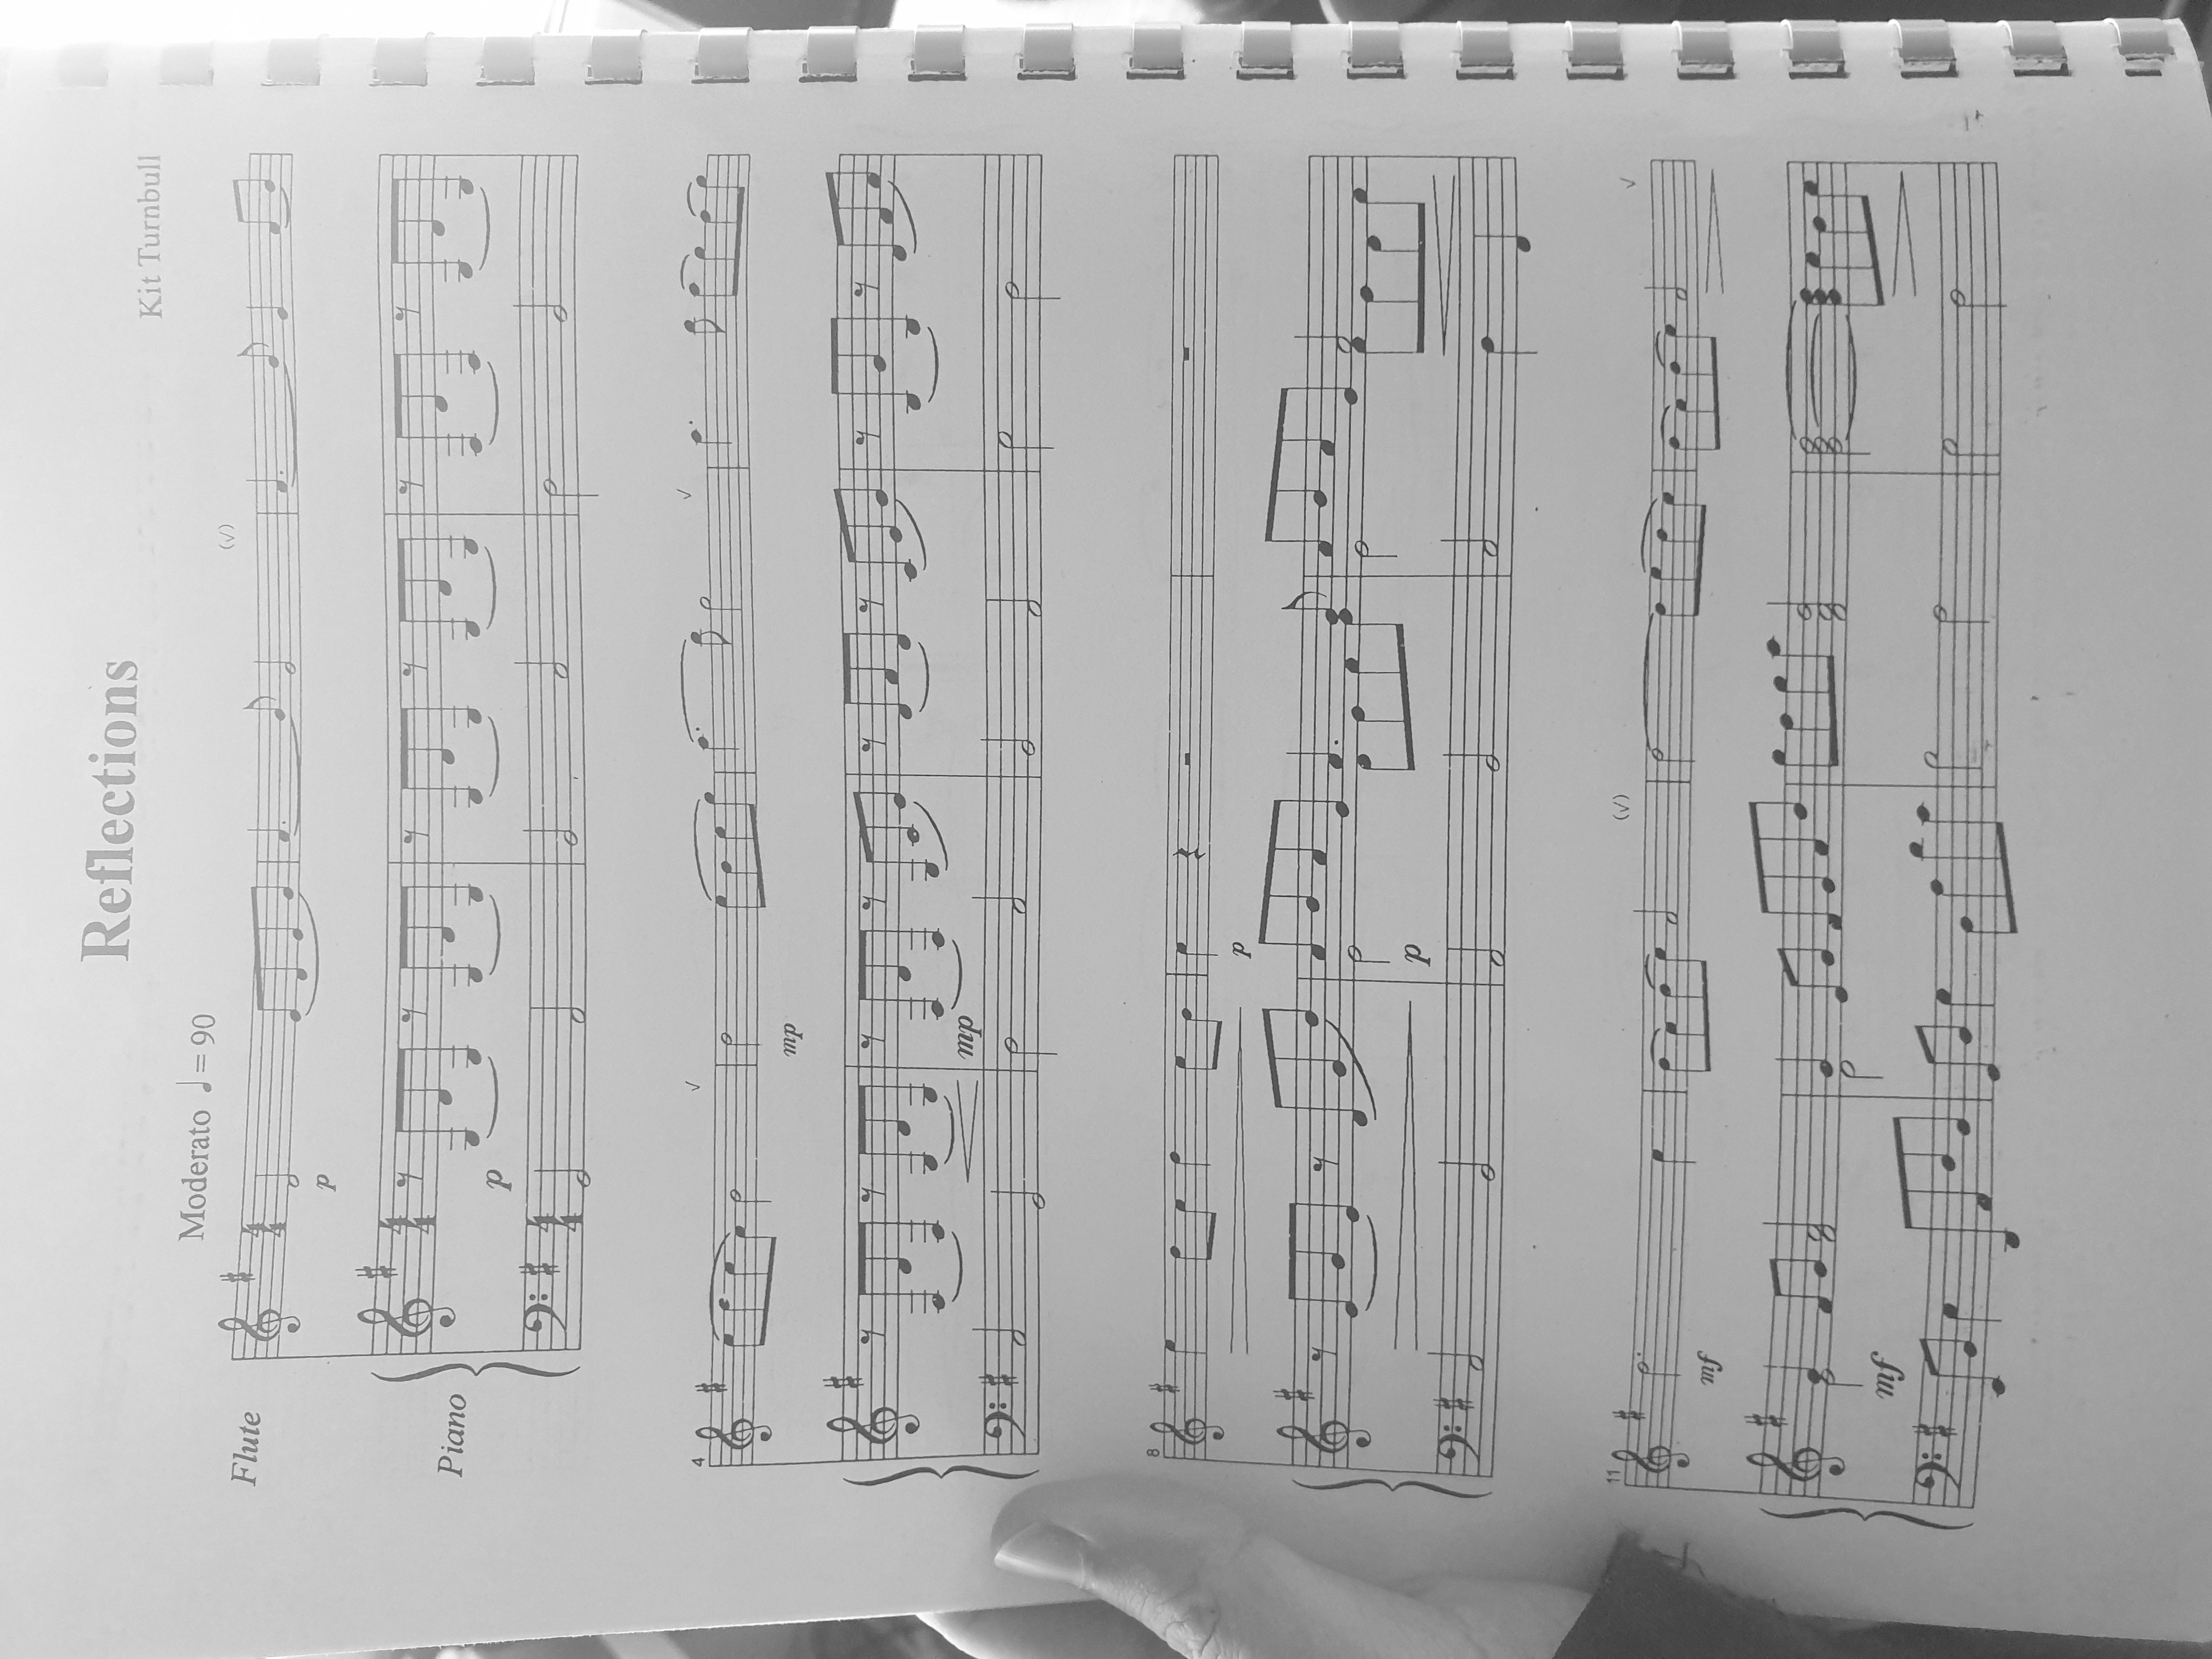

In [69]:
Image.fromarray(image_gray)

In [61]:
# Scale up or down overly tiny or large images
if src_h > 5500:
    pre_scale = 5000 / src_h
    image_gray = pyramid_reduce(image_gray, 1 / pre_scale, preserve_range=True).astype(np.uint8)
elif src_h < 1500:
    pre_scale = 2000 / src_h
    image_gray = cv2.resize(image_gray, None, fx=pre_scale, fy=pre_scale, interpolation=cv2.INTER_LINEAR)
else:
    pre_scale = 1

In [62]:
# Binarize Image
is_black_and_white = np.count_nonzero(image_gray == 255) + np.count_nonzero(image_gray == 0) == (image_gray.shape[0]*image_gray.shape[1])

if not is_black_and_white:
    tresh = 255 - cv2.ximgproc.niBlackThreshold(image_gray, 255, k=0.1, blockSize=51, type=cv2.THRESH_BINARY, binarizationMethod=cv2.ximgproc.BINARIZATION_SAUVOLA)
else:
    tresh = 255 - image_gray

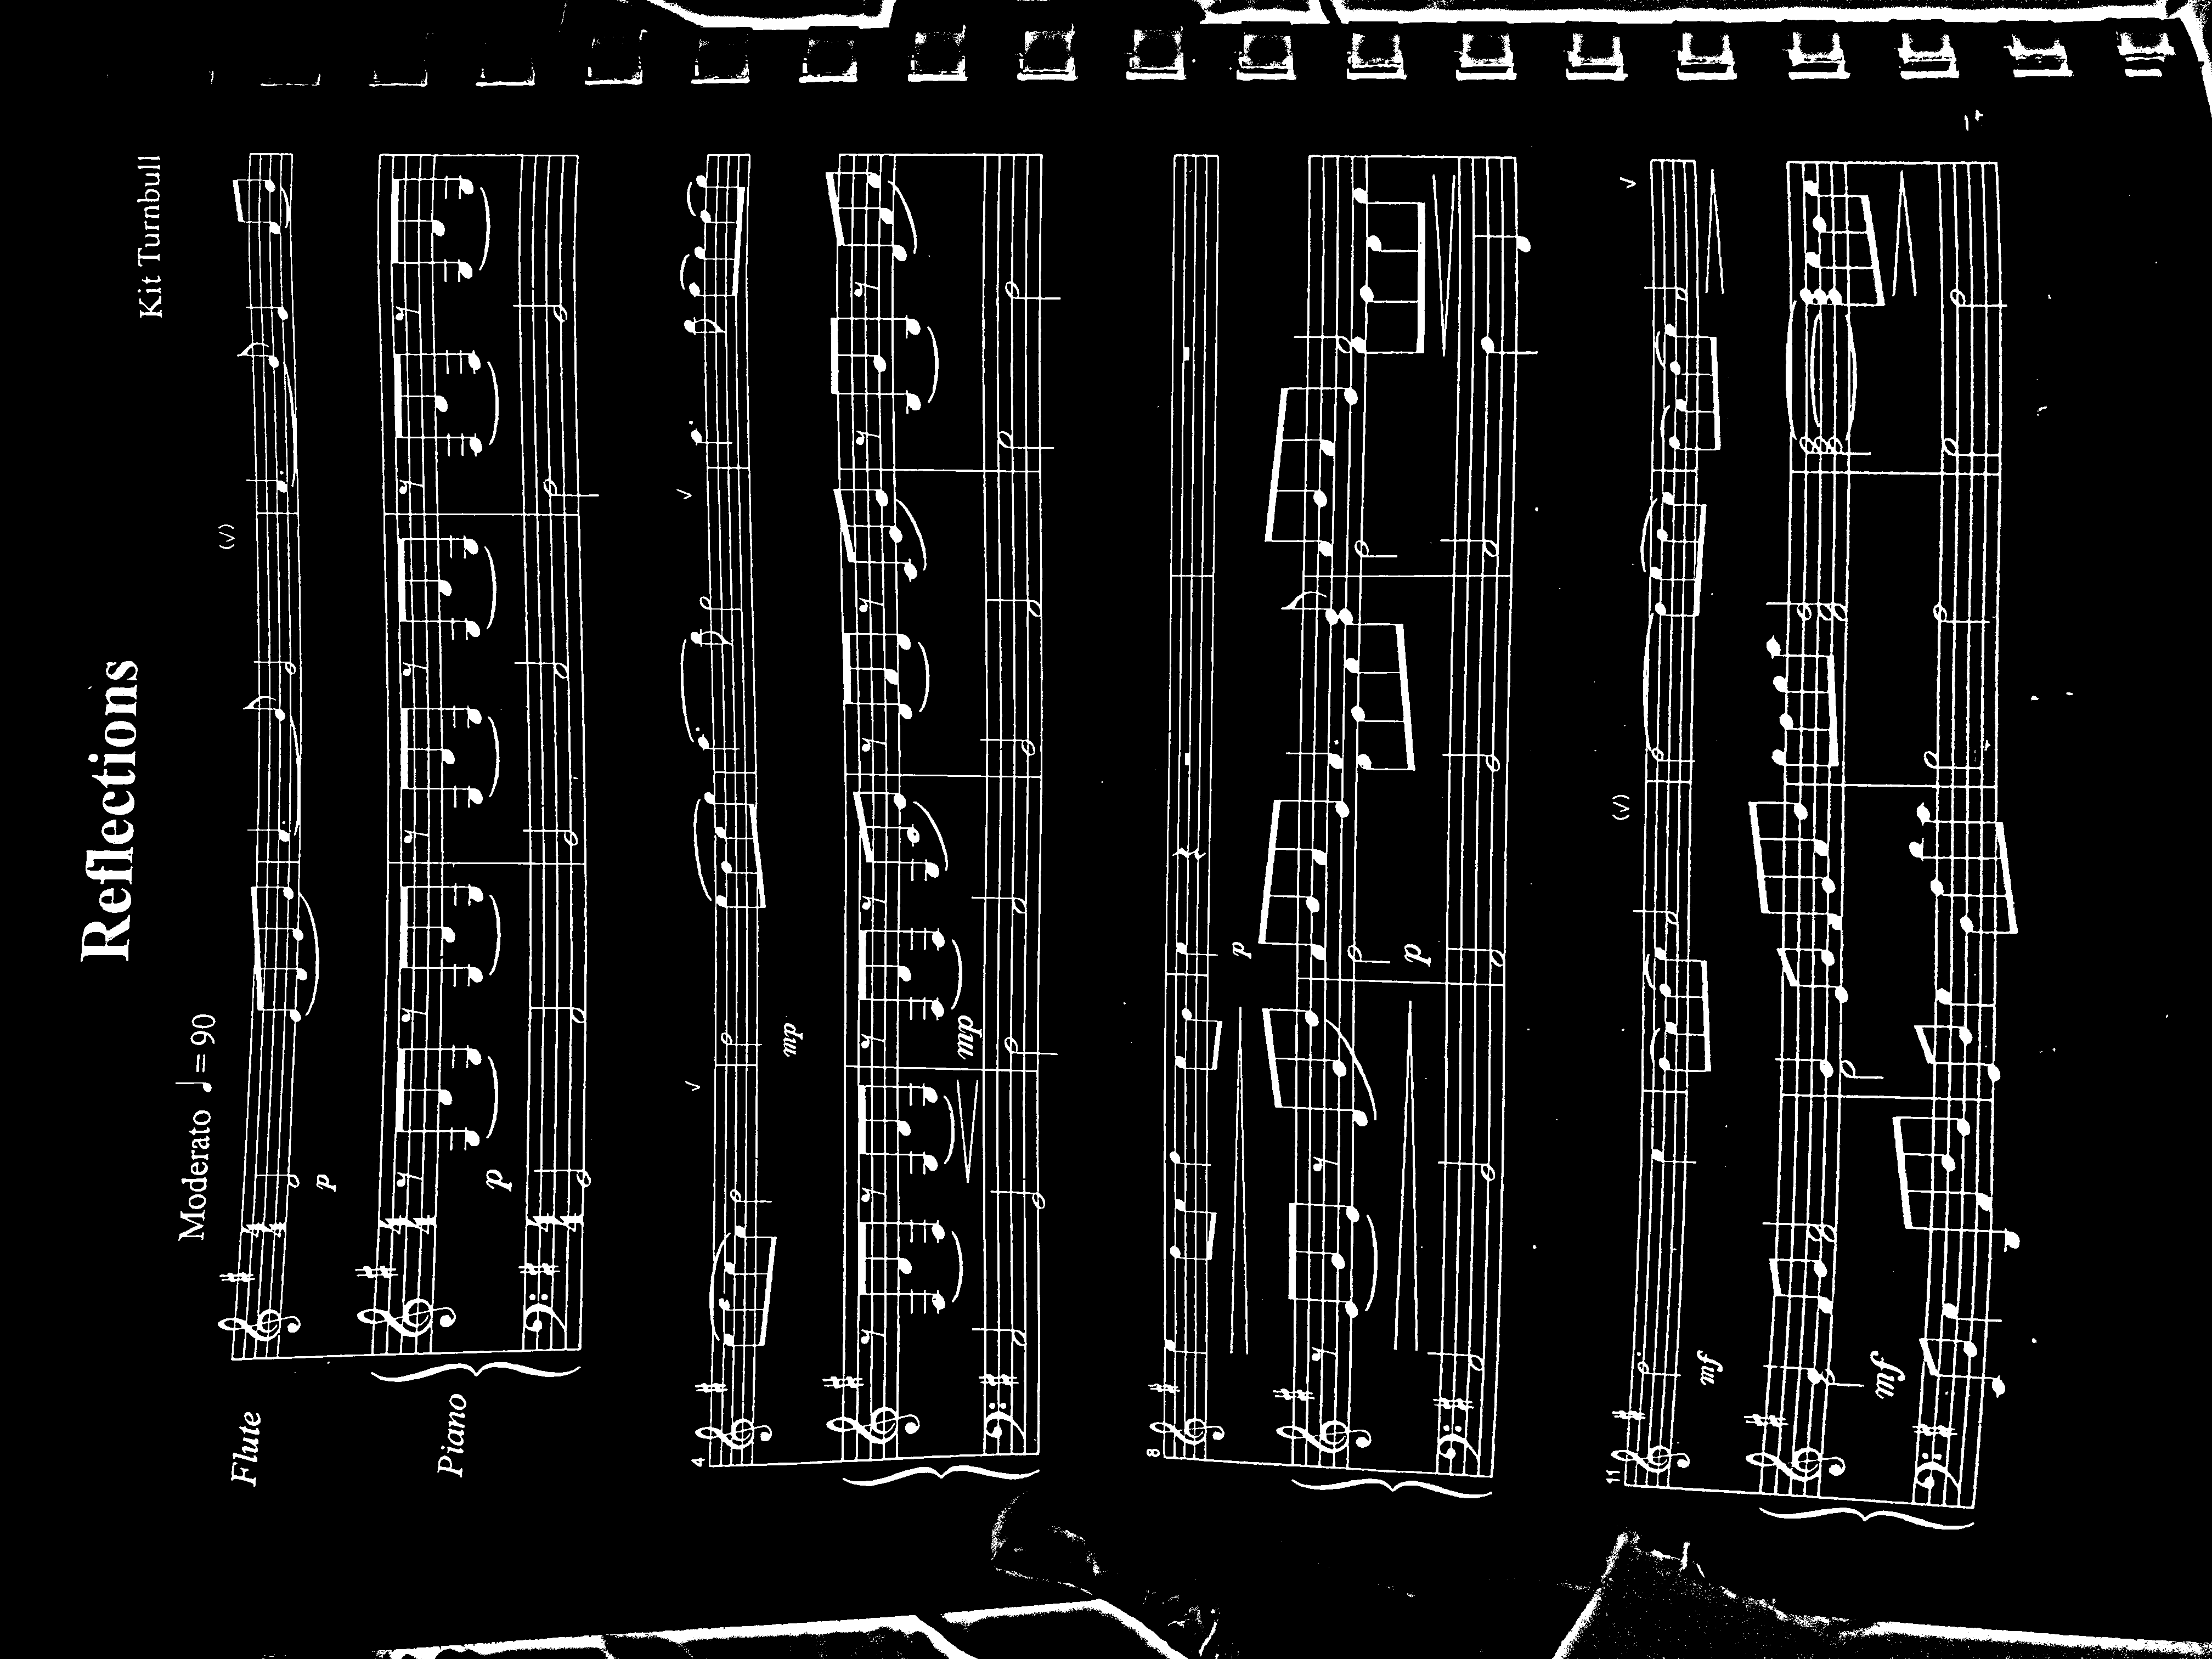

In [63]:

Image.fromarray(tresh)

In [51]:
closed = cv2.morphologyEx(tresh, op=cv2.MORPH_CLOSE, kernel=np.ones((3, 3)))

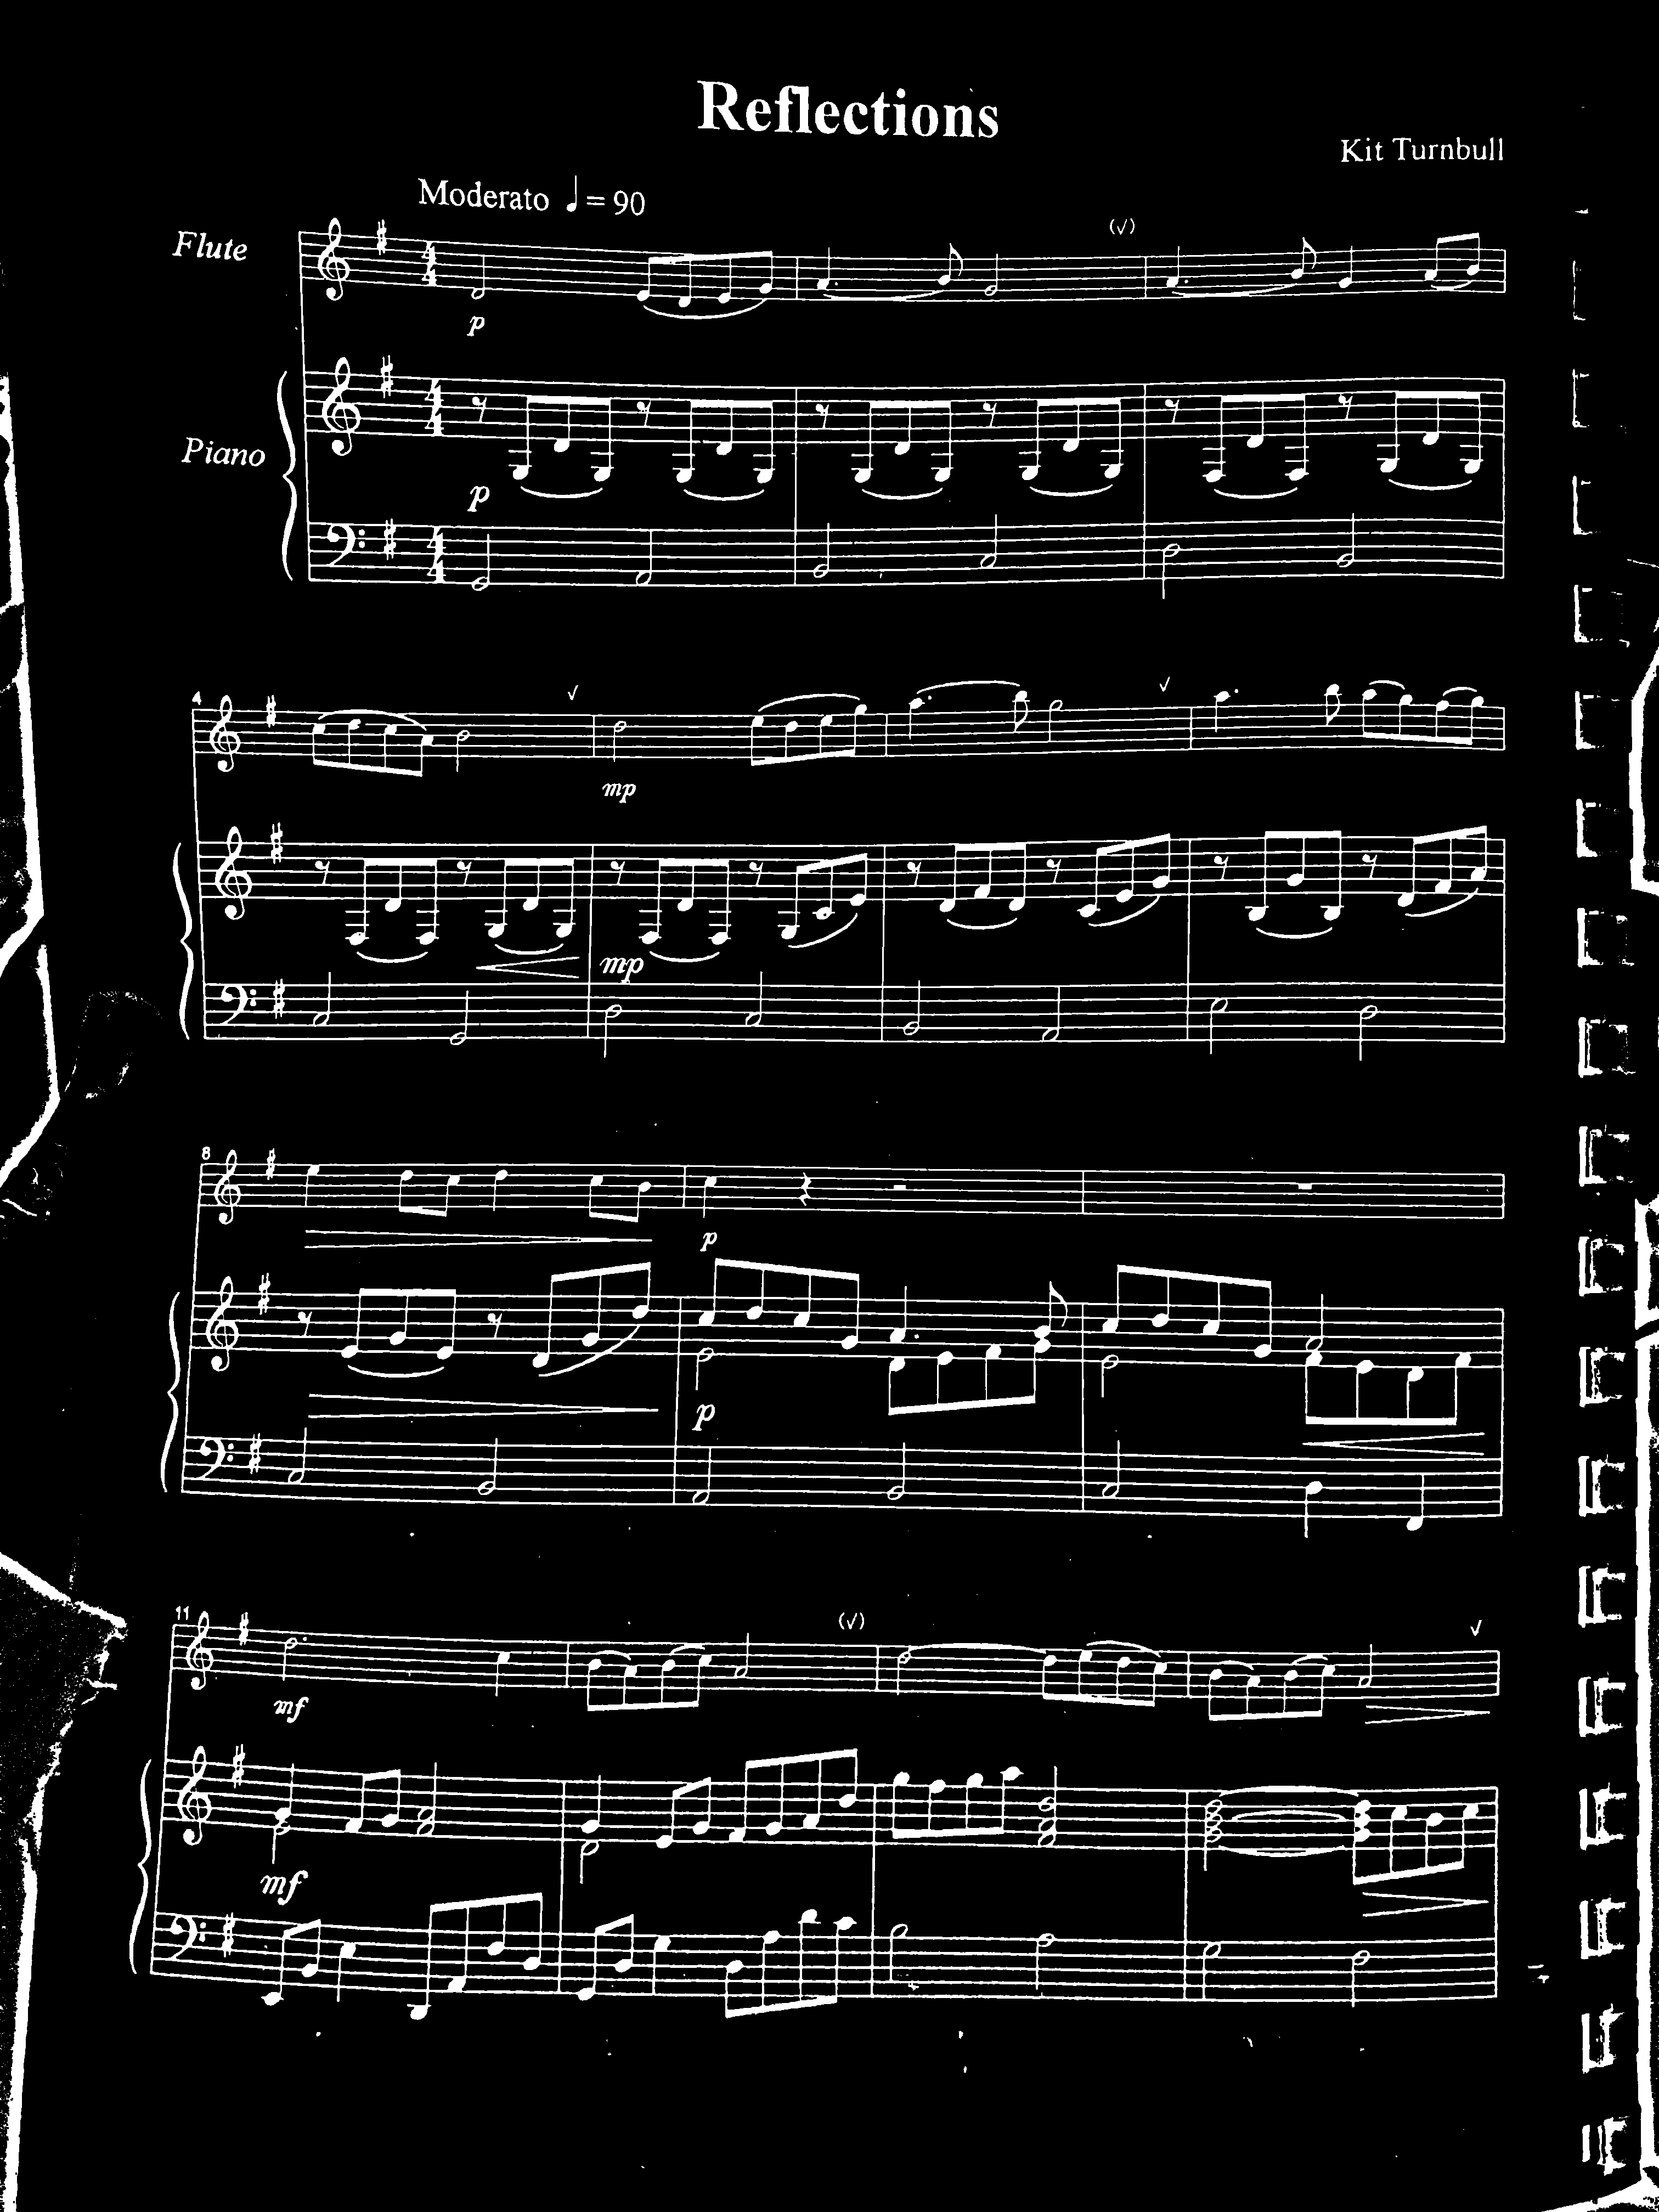

In [52]:
Image.fromarray(closed)

In [53]:
staff_height = 59

In [54]:
# Perform Hough Transform for quasi-horizontal lines on closed image
tested_angles = np.linspace(np.radians(85), np.radians(95), 1000)
h, theta, d = hough_line(closed, theta=tested_angles)
# Detect peaks in Hough Transform
_, angles, dists = hough_line_peaks(h, theta, d, min_distance=6, threshold=0.65 * h.max())
angles = np.degrees(angles)
if len(angles) == 0:
    print('Not enough staff lines detected.')
# Filter out outliers
valid_idxs = np.where(np.abs(np.mean(angles) - angles) < 0.4)
if len(valid_idxs[0]) == 0:
    print('Not enough staff lines detected.')
angles = angles[valid_idxs]
dists = dists[valid_idxs]
# Sort distances and compute interline differences between adjacent values
diff = np.diff(sorted(dists))
if len(diff) < 5 or len(angles) == 0:
    print('Not enough staff lines detected.')
# Compute global rotation angle
rotation = -90 + np.mean(angles)
# Get most common interline difference
hist, bin_edges = np.histogram(diff, bins=50)
max_bin = np.argmax(hist)
# Get exact value from histogram data
vals_in_bin = [val for val in diff if bin_edges[max_bin] <= val <= bin_edges[max_bin+1]]
val_mean = np.mean(vals_in_bin)
if val_mean == 0:
    print('Could not recognize scale.')
# Compute scaling factor from most common interline difference
scale = pre_scale * ((staff_height / 4) / val_mean)
if (scale > 7 or scale < 0.2):
    print('Unrealistic scaling factor of {scale}')

In [55]:
# Compute target image size
h, w = image.shape[:2]
dst_w = int(w * scale)
dst_h = int(h * scale)

In [56]:
if scale >= 1:
    scaled = cv2.resize(tresh, (dst_w, dst_h), scale, interpolation=cv2.INTER_CUBIC)
else:
    scaled = pyramid_reduce(tresh, 1 / scale, preserve_range=True).astype(np.uint8)

In [57]:
M = cv2.getRotationMatrix2D((dst_w//2, dst_h//2), rotation, 1)
rotated = cv2.warpAffine(scaled, M, (dst_w, dst_h), borderMode=cv2.BORDER_REFLECT)

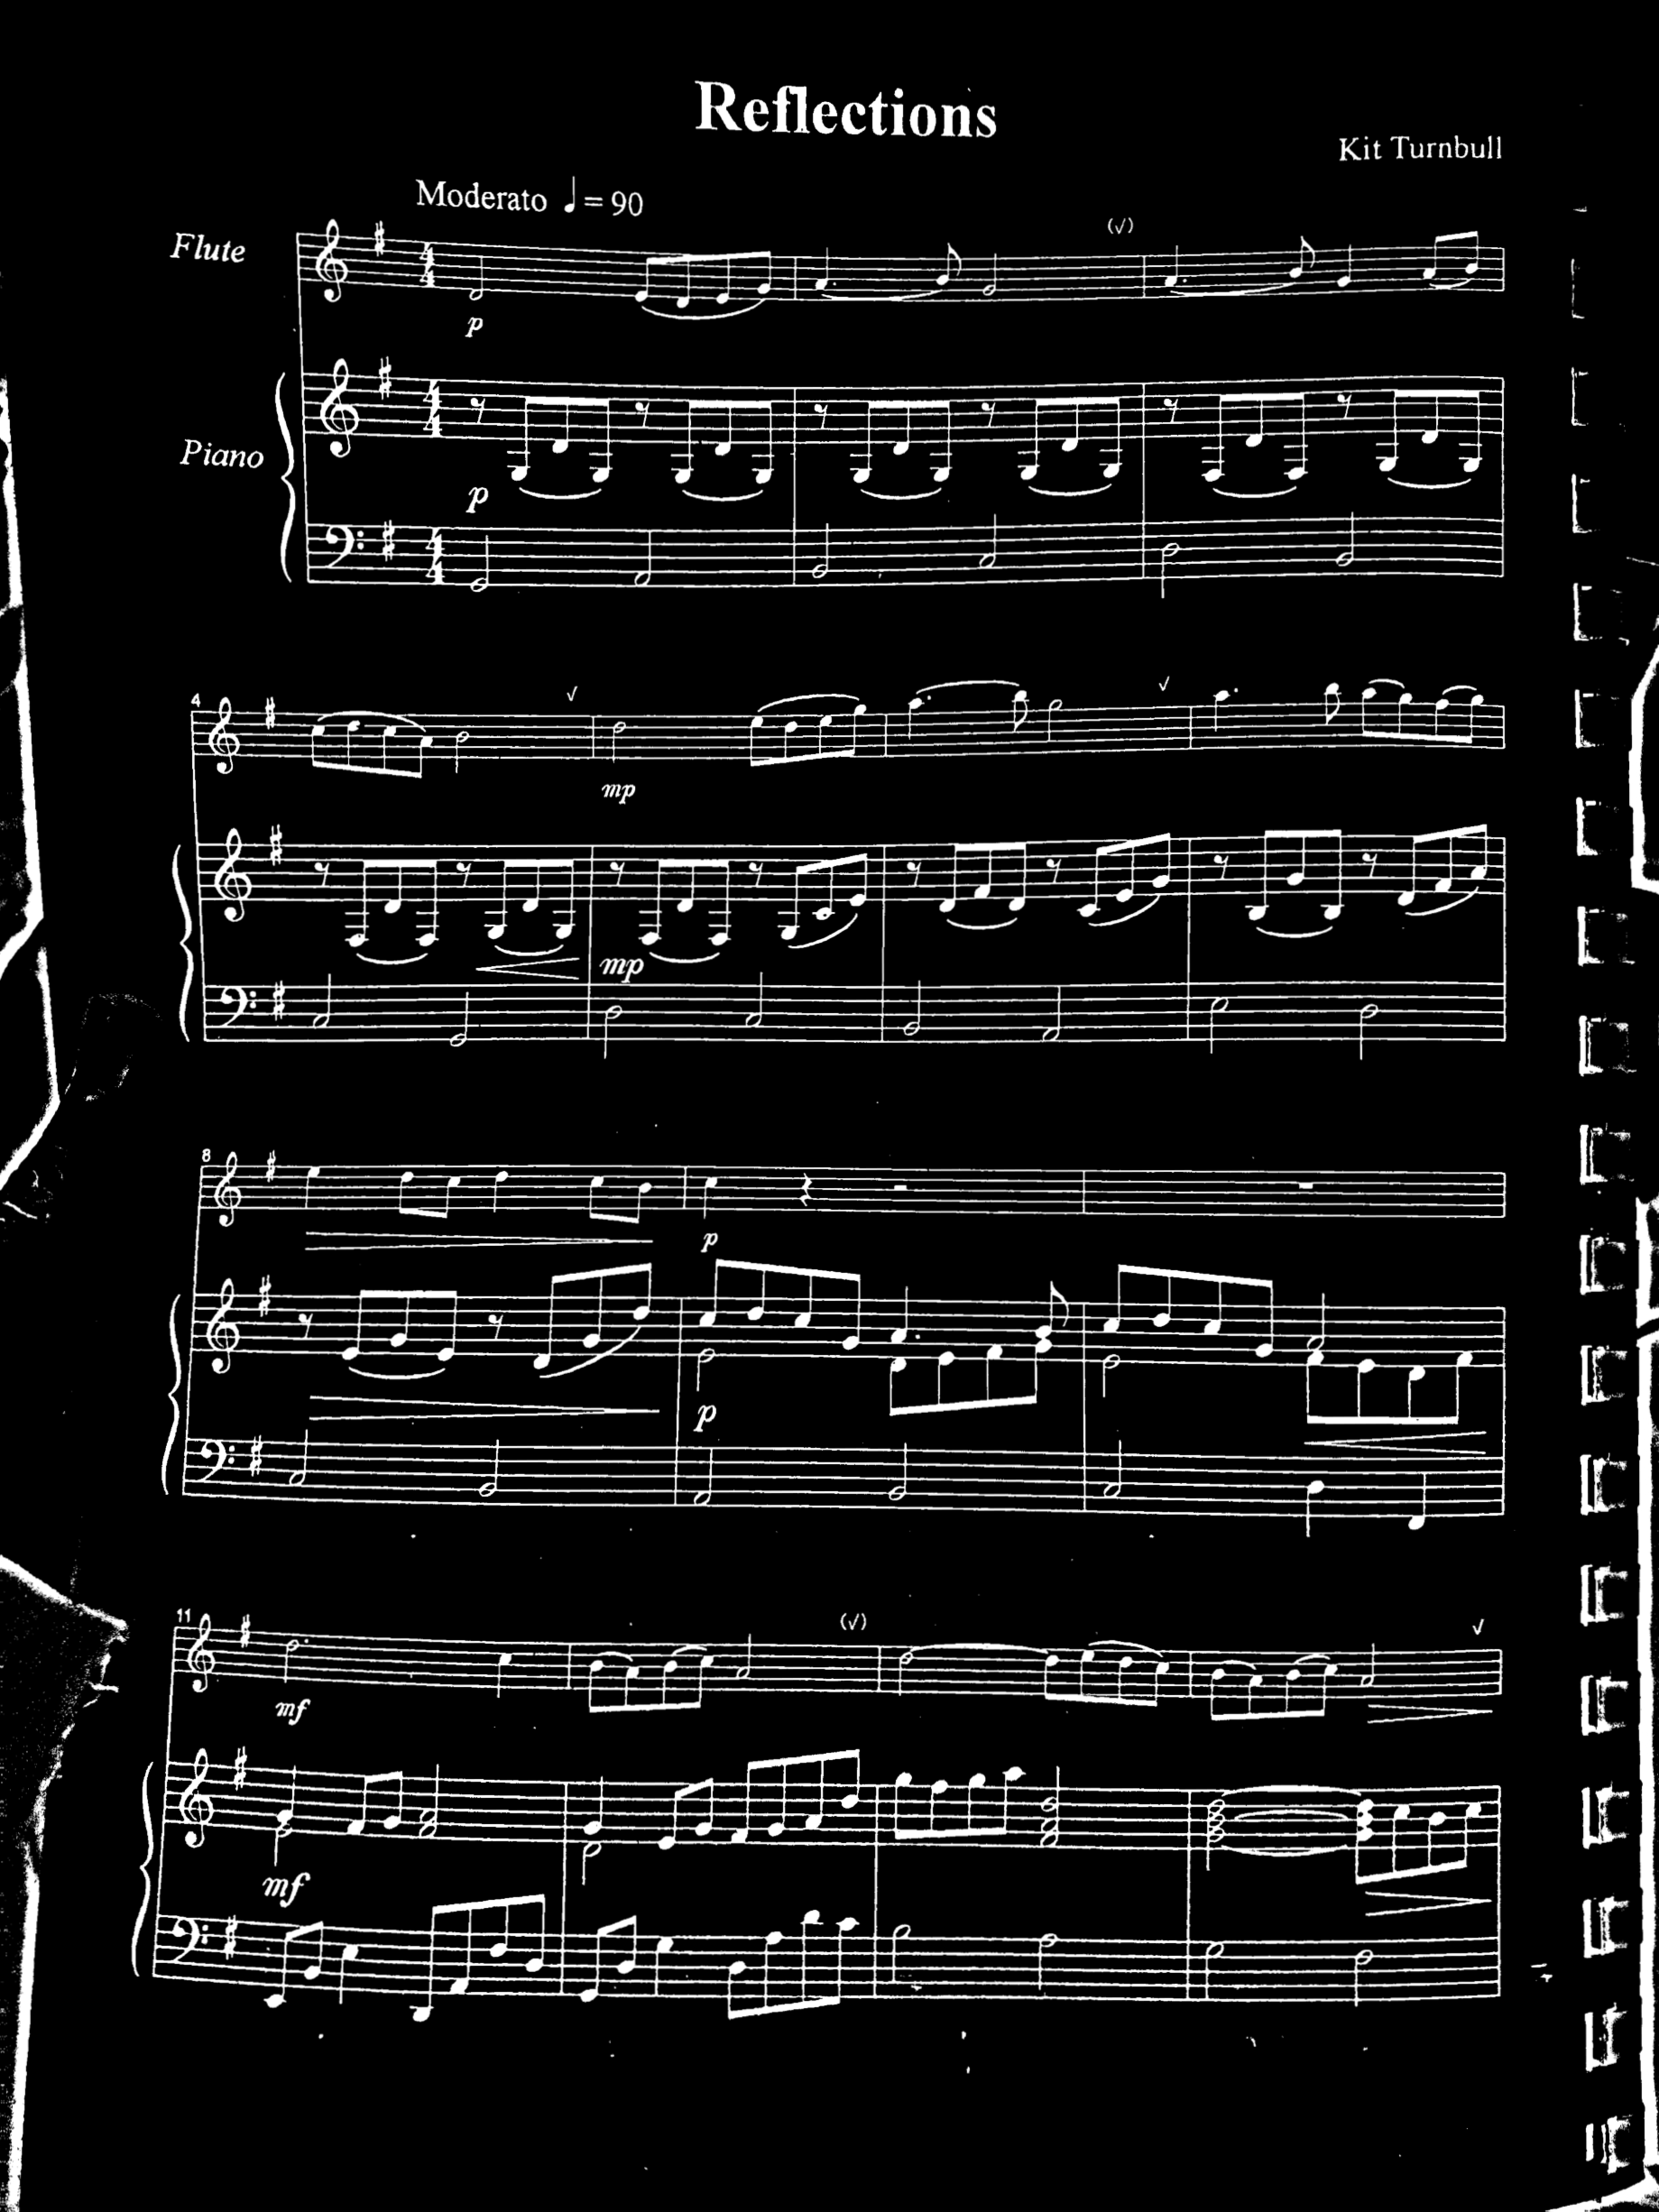

In [58]:
output_image = Image.fromarray(rotated)
output_image

In [59]:
output_image.save("output.png")